In [ ]:
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import imagenet_utils
from imutils.object_detection import non_max_suppression
from tensorflow.keras.models import load_model
from keras import backend as K
import tensorflow as tf

import json
import numpy as np
import argparse
import imutils
import time
import cv2
import matplotlib.pyplot as plt

In [ ]:
required = {
    "image" : "images/kabir.jpeg",          # images to predict labels for
    "size" : (400,450),                     # size for region of interest 
    "min_conf" : 0.98                       # threshold for prediction
}

In [ ]:
WIDTH = 800
PYR_SCALE = 1.5
WIN_STEP = 16
ROI_SIZE = required["size"]
INPUT_SIZE = (299, 299)

In [ ]:
def sliding_window(image, step, ws):
    """ 
    returns multiple smaller images of speicified dimension and stride 
    """

    for y in range(0, image.shape[0] - ws[1], step):
        for x in range(0, image.shape[1] - ws[0], step):
            yield (x, y, image[y:y + ws[1], x:x + ws[0]])

In [ ]:
def image_pyramid(image, scale=1.5, minSize=(250, 250)):
    """ 
    returns images with smaller dimension comapred to original for 
    better detection in case the object is placed close to camera
    """
    
    yield image

    while True:

        w = int(image.shape[1] / scale)
        image = imutils.resize(image, width=w)

        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break

        yield image

In [ ]:
def image_pyramid_box( original_image , W , H):
    """
    applies image pyramid and sliding window to get final collection of images
    """
    rois = []
    locs = []
    
    pyramid = image_pyramid(original_image, scale=PYR_SCALE, minSize=ROI_SIZE)
    
    for image in pyramid:

        scale = W / float(image.shape[1])

        for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):

            x = int(x * scale)
            y = int(y * scale)
            w = int(ROI_SIZE[0] * scale)
            h = int(ROI_SIZE[1] * scale)

            roi = cv2.resize(roiOrig, INPUT_SIZE)
            roi = img_to_array(roi)
            roi = preprocess_input(roi)

            rois.append(roi)
            locs.append((x, y, x + w, y + h))
    return rois , locs

In [ ]:
# implementation of F!-Score

def recall_m(y_true, y_pred):

    y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), 0.5), K.floatx())
    true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.clip(y_true, 0, 1))
    recall_ratio = true_positives / (possible_positives + K.epsilon())
    return recall_ratio

def precision_m(y_true, y_pred):

    y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), 0.5), K.floatx())
    true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(y_pred)
    precision_ratio = true_positives / (predicted_positives + K.epsilon())
    return precision_ratio

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
def get_label_dict():
    """
    gets dictionary of labels
    """
    
    f = open("dict.json","r")
    j = json.loads( f.read() )
    f.close()
    return j

In [ ]:
def get_boxes(pred , preds, locs, j ):
    """
    returns boxes with corresponding required probability
    """

    labels = {}

    for i in range(len(pred)):

        label = j[ str( pred[i] )]
        prob = preds[i][pred[i]]
        
        if prob >= required["min_conf"]:
            
            box = locs[i]        
            L = labels.get(label, [])
            L.append((box, prob))
            labels[label] = L
    
    return labels

In [ ]:
def get_final_labels(original_image,labels):

    clone = original_image.copy()

    for label in labels.keys():

        boxes = np.array([p[0] for p in labels[label]])
        proba = np.array([p[1] for p in labels[label]])
        boxes = non_max_suppression(boxes, proba)

        for (startX, startY, endX, endY) in boxes:

            cv2.rectangle(clone, (startX, startY), 
                          (endX, endY),(0, 255, 0), 2)
            
            y = startY - 10 if startY - 10 > 10 else startY + 10
            
            cv2.putText(clone, label.split('_')[-1], (startX, y),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3)
            
        print(label.split('_')[-1])
            
        plt.imshow(clone) 
        plt.show()

    clone = cv2.cvtColor(clone, cv2.COLOR_RGB2BGR)
    cv2.imwrite('images/label.jpeg', clone)

In [ ]:
def main():
    
    orig = cv2.imread(required["image"])
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    orig = imutils.resize(orig, width=WIDTH)
    (H, W) = orig.shape[:2]

    model = load_model('model.h5',custom_objects={"f1_m": f1_m})

    rois , locs = image_pyramid_box( orig , W , H)

    rois = np.array(rois, dtype="float32")

    preds = np.array(model.predict(rois))

    pred_argmax = np.array([np.argmax(i) for i in preds])

    j = get_label_dict()

    labels = get_boxes(pred_argmax , preds , locs, j)

    get_final_labels(orig,labels)

shirt


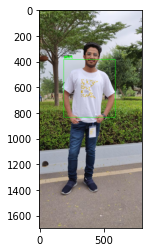

shoes


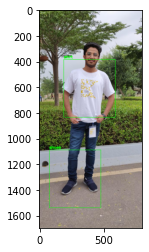

pants


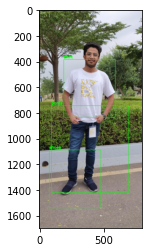

In [ ]:
main()